## Customer Onboarding Efficiency

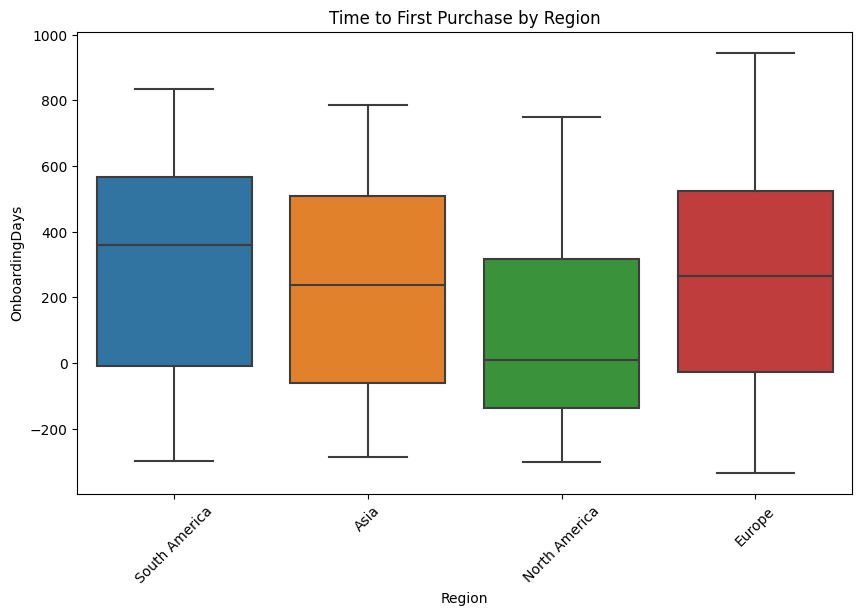

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
customers = pd.read_csv('/kaggle/input/zeotap-dataset/Customers.csv', parse_dates=['SignupDate'])
transactions = pd.read_csv('/kaggle/input/zeotap-dataset/Transactions.csv', parse_dates=['TransactionDate'])

# Merge data
merged = pd.merge(customers, transactions, on='CustomerID', how='inner')

# Calculate time to first purchase
first_purchase = merged.groupby('CustomerID')['TransactionDate'].min().reset_index()
onboarding = pd.merge(customers, first_purchase, on='CustomerID')
onboarding['OnboardingDays'] = (onboarding['TransactionDate'] - onboarding['SignupDate']).dt.days

# Analyze by region
plt.figure(figsize=(10, 6))
sns.boxplot(data=onboarding, x='Region', y='OnboardingDays')
plt.title('Time to First Purchase by Region')
plt.xticks(rotation=45)
plt.show()

## Regional Product Preferences

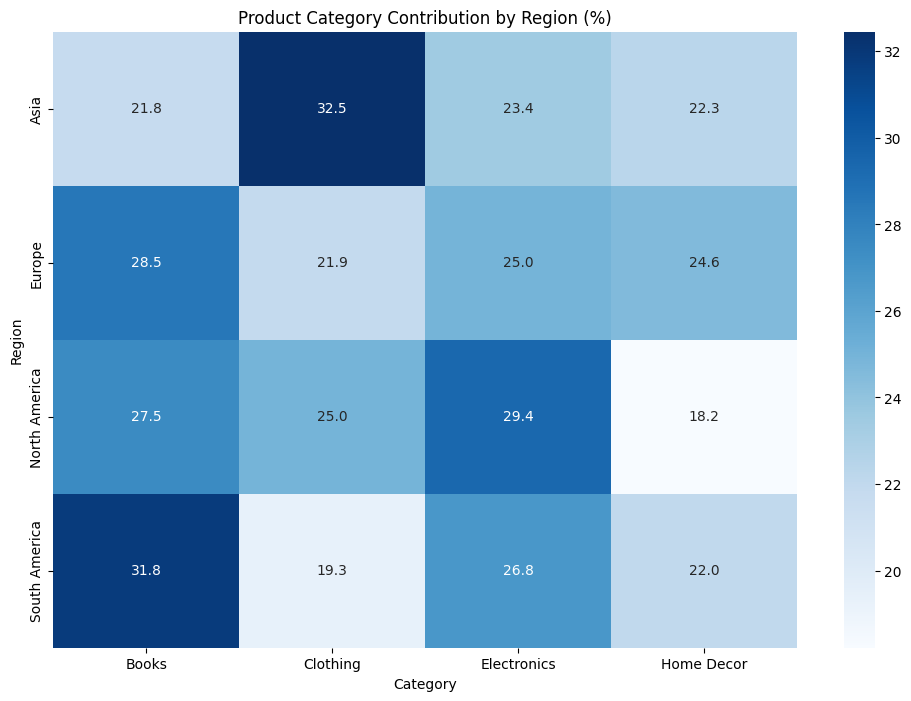

In [4]:
# Merge all three datasets
products=pd.read_csv("/kaggle/input/zeotap-dataset/Products.csv")
full_data = pd.merge(
    pd.merge(transactions, customers, on='CustomerID'),
    products, on='ProductID'
)

# Calculate category contributions per region
region_category = full_data.groupby(['Region', 'Category'])['TotalValue'].sum().unstack()
region_category_pct = region_category.div(region_category.sum(axis=1), axis=0) * 100

# Heatmap visualization
plt.figure(figsize=(12, 8))
sns.heatmap(region_category_pct, annot=True, cmap='Blues', fmt='.1f')
plt.title('Product Category Contribution by Region (%)')
plt.show()

## Customer Loyalty & Repeat Purchases

<ipython-input-5-11466e8ef5d8>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_spending = cohort_analysis.groupby('Cohort')['TotalValue'].mean().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


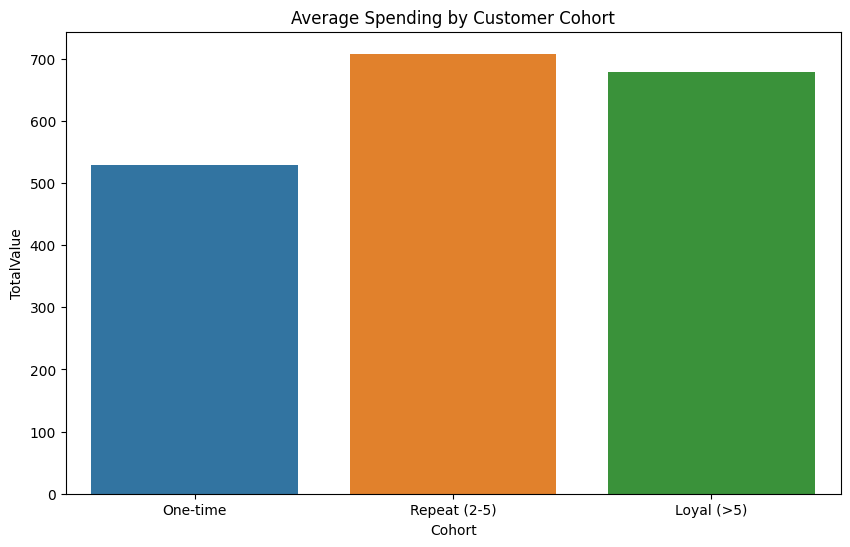

In [5]:
# Calculate transaction counts per customer
transaction_counts = transactions.groupby('CustomerID')['TransactionID'].count().reset_index(name='TransactionCount')

# Segment into cohorts
transaction_counts['Cohort'] = pd.cut(
    transaction_counts['TransactionCount'],
    bins=[0, 1, 5, float('inf')],
    labels=['One-time', 'Repeat (2-5)', 'Loyal (>5)']
)

# Merge with transaction data for spending analysis
cohort_analysis = pd.merge(transaction_counts, transactions, on='CustomerID')
cohort_spending = cohort_analysis.groupby('Cohort')['TotalValue'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=cohort_spending, x='Cohort', y='TotalValue')
plt.title('Average Spending by Customer Cohort')
plt.show()

## Inventory Turnover & Sales Velocity

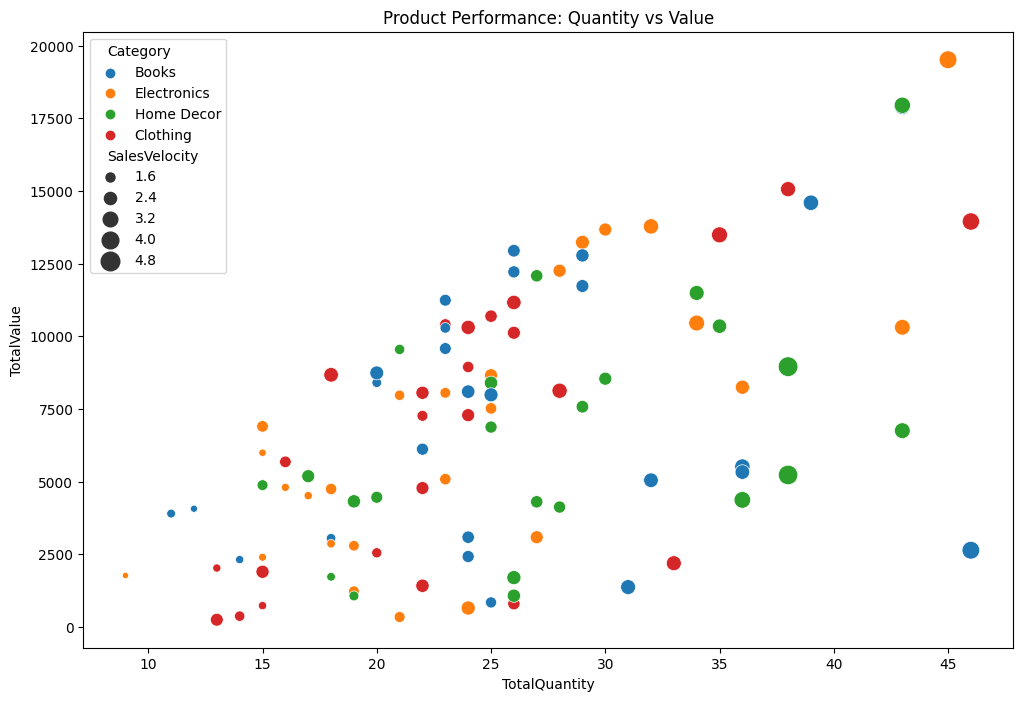

In [6]:
# Aggregate product performance
product_performance = transactions.groupby('ProductID').agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalValue=('TotalValue', 'sum'),
    FirstSale=('TransactionDate', 'min'),
    LastSale=('TransactionDate', 'max')
).reset_index()

# Calculate sales velocity (items/month)
product_performance['SalesMonths'] = (
    (product_performance['LastSale'] - product_performance['FirstSale']).dt.days / 30
).clip(lower=1)  # Avoid division by zero
product_performance['SalesVelocity'] = product_performance['TotalQuantity'] / product_performance['SalesMonths']

# Merge with product details
product_performance = pd.merge(product_performance, products, on='ProductID')

# Identify low-margin items
low_margin = product_performance[
    (product_performance['TotalQuantity'] > product_performance['TotalQuantity'].median()) &
    (product_performance['TotalValue'] < product_performance['TotalValue'].median())
]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=product_performance,
    x='TotalQuantity',
    y='TotalValue',
    hue='Category',
    size='SalesVelocity',
    sizes=(20, 200)
)
plt.title('Product Performance: Quantity vs Value')
plt.show()

##  Repeat Purchase Rate Analysis

Repeat Purchase Rate (RPR): 93.97%


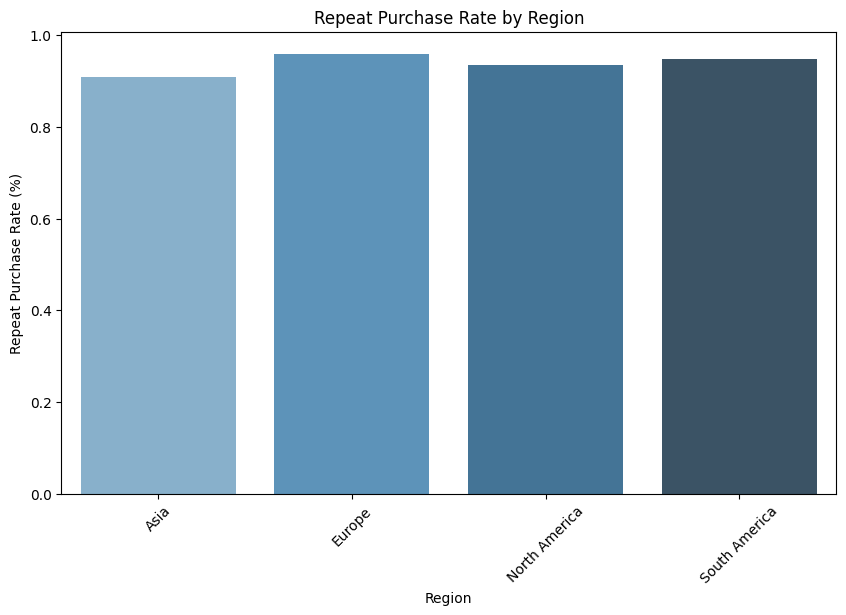

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load transactions data
transactions = pd.read_csv('/kaggle/input/zeotap-dataset/Transactions.csv')

# Calculate repeat purchase rate
repeat_customers = transactions.groupby('CustomerID')['TransactionID'].count().reset_index(name='TransactionCount')
repeat_customers['IsRepeat'] = repeat_customers['TransactionCount'] > 1

# Calculate overall RPR
total_customers = repeat_customers['CustomerID'].nunique()
repeat_customers_count = repeat_customers[repeat_customers['IsRepeat']]['CustomerID'].nunique()
rpr = (repeat_customers_count / total_customers) * 100

print(f"Repeat Purchase Rate (RPR): {rpr:.2f}%")

# Analyze RPR by region (merge with Customers.csv)
customers = pd.read_csv('/kaggle/input/zeotap-dataset/Customers.csv')
repeat_by_region = pd.merge(repeat_customers, customers, on='CustomerID', how='left')
repeat_by_region = repeat_by_region.groupby('Region')['IsRepeat'].mean().reset_index(name='RPR')

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=repeat_by_region, x='Region', y='RPR', palette='Blues_d')
plt.title('Repeat Purchase Rate by Region')
plt.ylabel('Repeat Purchase Rate (%)')
plt.xticks(rotation=45)
plt.show()

## Average Order Value Trends

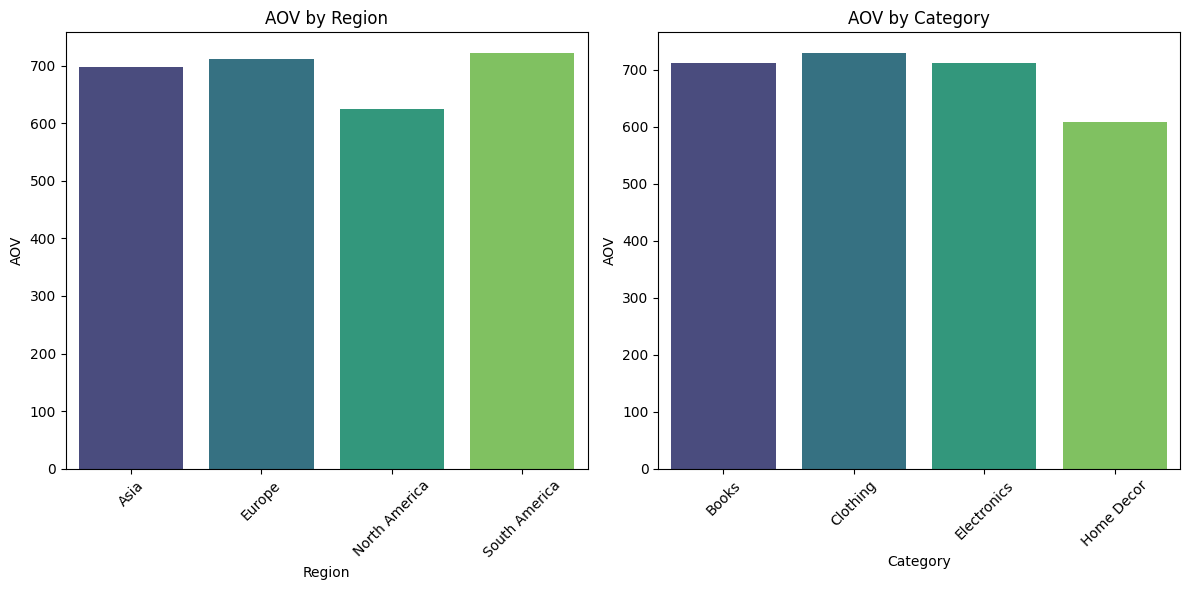

<ipython-input-8-d5e08eb1994a>:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_aov = transactions.groupby(pd.Grouper(key='TransactionDate', freq='M'))['TotalValue'].mean().reset_index()
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


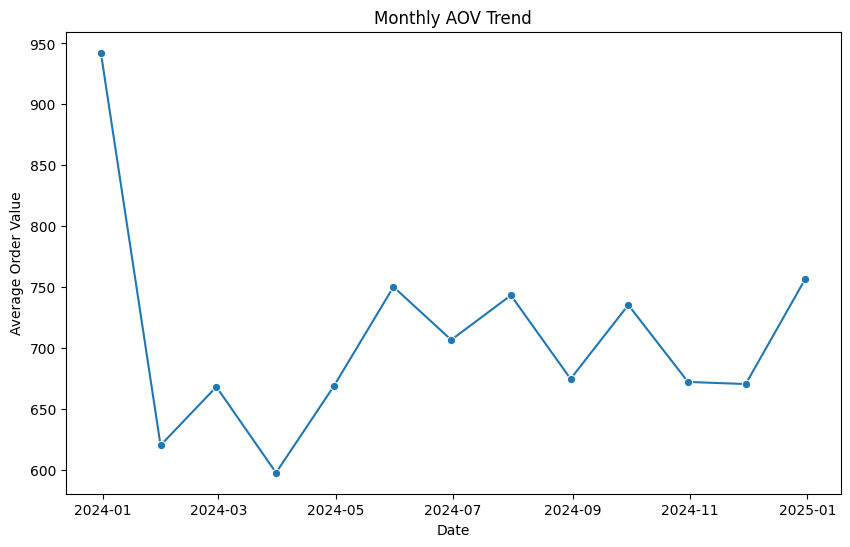

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
transactions = pd.read_csv('/kaggle/input/zeotap-dataset/Transactions.csv')
customers = pd.read_csv('/kaggle/input/zeotap-dataset/Customers.csv')
products = pd.read_csv('/kaggle/input/zeotap-dataset/Products.csv')

# Calculate total value per transaction (AOV)
transaction_totals = transactions.groupby('TransactionID').agg({
    'TotalValue': 'sum',
    'CustomerID': 'first'
}).reset_index()

# Merge with customer and product data
merged = pd.merge(transaction_totals, customers, on='CustomerID')
merged = pd.merge(merged, transactions[['TransactionID', 'ProductID']], on='TransactionID')
merged = pd.merge(merged, products[['ProductID', 'Category']], on='ProductID')

# Calculate AOV by region and category
aov_region = merged.groupby('Region')['TotalValue'].mean().reset_index(name='AOV')
aov_category = merged.groupby('Category')['TotalValue'].mean().reset_index(name='AOV')

# Plot AOV trends
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=aov_region, x='Region', y='AOV', palette='viridis')
plt.title('AOV by Region')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=aov_category, x='Category', y='AOV', palette='viridis')
plt.title('AOV by Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Track AOV over time
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
monthly_aov = transactions.groupby(pd.Grouper(key='TransactionDate', freq='M'))['TotalValue'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_aov, x='TransactionDate', y='TotalValue', marker='o')
plt.title('Monthly AOV Trend')
plt.xlabel('Date')
plt.ylabel('Average Order Value')
plt.show()